This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2359
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:      198

Total number of variables............................:      600
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      397
Total number of inequality constraints...............:      600
        inequality constraints with only lower bounds:      300
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      300

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1137500e+07 1.00e+02 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

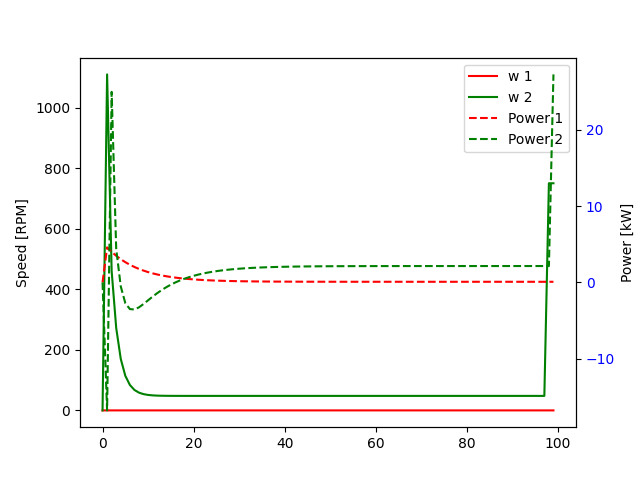

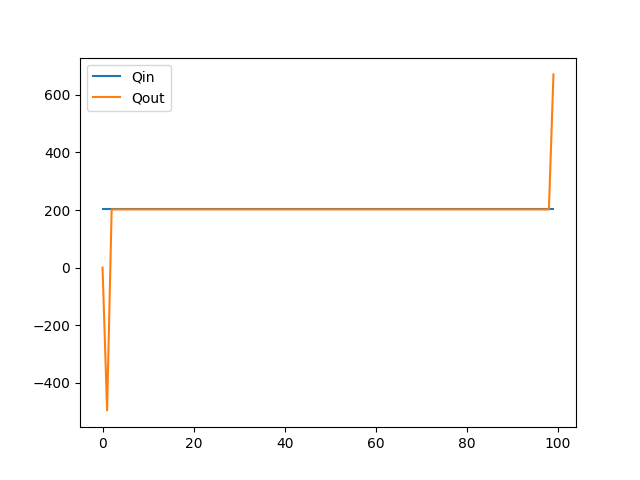

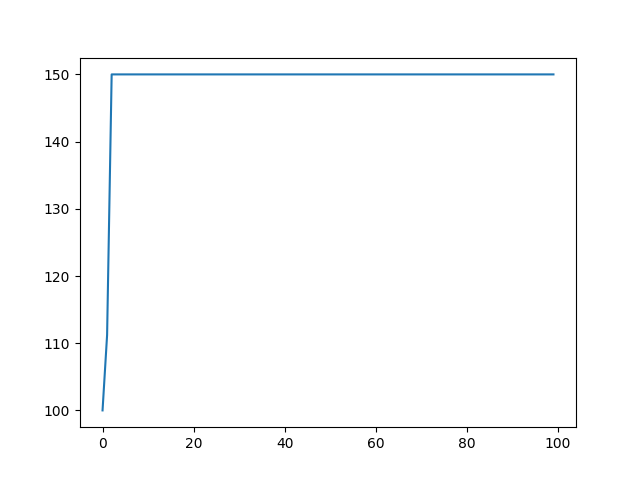

In [21]:
%matplotlib widget
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

plt.close("all")

# Create an Opti instance
opti = ca.Opti()

#=========== Parameters of the ARX model
#A (ny x (na1+na2)) na1,2: lags on y1,2
A_power = np.array([[8.6870E-01,0],[0,8.7838E-01]])
A_outflow = np.array([[1.0869,-1.5832E-01]])

# B (ny x (nb1+nb2)) nb1,2: lags on u1,2
B_power = np.array([[2.7560E-02,0,-2.2282E-02,0],[0,3.5775E-02,0,-3.0685E-02]])
B_outflow = np.array([[4.2454E-01,6.6812E-01,-3.6354E-01,-3.6354E-01]])

C_power = np.array([1.0790E-02,1.7240E-02])
C_outflow = np.array([-1.5832E-01])

#=========== Desired value of y 
h_des = opti.parameter()
Qout_meas = opti.parameter()
Qin_est = opti.parameter()
#w1_meas =  opti.parameter()

h_des = 150
Qout_meas = 0
Qin_est = 202
#w1_meas.set_value(1000) 

#=========== Define the Horizon
N = 100  

#=========== Declare Symbolic Variables (SISO but can be extended to MIMO or MISO)
Qout = opti.variable(N)
Qin = opti.variable(N)
P = opti.variable(2,N)
w = opti.variable(2,N)
h = opti.variable(N)
Qin[:] = Qin_est


#=========== Objective function
# Minimize the deviation of y from yd and control effort
objective = 0
for t in range(1, N):
    objective += 5*(h[t] - h_des)**2 + 0.1*w[0,t]**2  

opti.minimize(objective)

# ARX model constraints
for t in range(2, N):
    #opti.subject_to(Qout[t] == 1.2995 * Qout[t-1] -4.3918E-01 * Qout[t-2] + 7.1049E-02 * w[0,t] + 0)
    opti.subject_to(Qout[t] == A_outflow @ ca.vcat([Qout[t-1],Qout[t-2]]) +B_outflow @ ca.vcat([w[:,t-1],w[:,t-2]]) + C_outflow)
    opti.subject_to(P[:,t] == A_power @ P[:,t-1] +B_power @ ca.vcat([w[:,t-1],w[:,t-2]]) + C_power)

Ts = 1 # ?
A = 18

for t in range(1, N):    
    opti.subject_to(h[t] == h[t-1] + Ts/A*(Qin[t-1]-Qout[t-1]))

# Additional constraints (e.g., on control input)
for t in range(N):
    opti.subject_to(w[:,t] >= 0)  # Lower bound on control input
    opti.subject_to(w[:,t] <= 1500)   # Upper bound on control input
    # opti.subject_to(Qout[t] >= 0)
    opti.subject_to(h[t] >= 0)  # Lower bound on control input
    opti.subject_to(h[t] <= 200)   # Upper bound on control input

# Initial conditions
opti.subject_to(Qout[0:1] == Qout_meas)  # Initial value of y, read from sensor
opti.subject_to(w[:,0] == [0,0])
opti.subject_to(h[0] == 100)
#opti.subject_to(u[0] == measured_speed)  # Initial value of u, read from sensor

# Solver options
opts = {
    #"qpsol": "ipopt",
    #"convexify_strategy": "regularize",
    "print_time": 0,
    #"print_iteration": 0,
    #"print_header": 0,
    "verbose": False,
    "error_on_fail": False
}

#opti.solver("sqpmethod", opts)
opti.solver('ipopt',opts)

sol = opti.solve();   # actual solve


plt.clf()    
ax1 = plt.subplot(1,1,1)
plt.plot(sol.value(w)[0,:],"r",label='w 1')
plt.plot(sol.value(w)[1,:],"g",label='w 2')
plt.ylabel('Speed [RPM]')
ax12 = ax1.twinx()
ax12.plot(sol.value(P)[0,:],"r--",label='Power 1')
ax12.plot(sol.value(P)[1,:],"g--",label='Power 2')
ax12.set_ylabel('Power [kW]')
ax12.tick_params(axis ='y', labelcolor = 'blue')
h1, l1 = ax1.get_legend_handles_labels()
h12, l12 = ax12.get_legend_handles_labels()
ax1.legend(h1+h12, l1+l12, loc=1) 
plt.show()

plt.figure()
plt.plot(sol.value(h),label='h')
plt.figure()
plt.plot(sol.value(Qin),label='Qin')
plt.plot(sol.value(Qout),label='Qout')
plt.legend()
plt.show()
